<center><h1>Final Project</h1></center>
<center><h3>Methods in Quantitative Biology</h3></center>

Given a 2s audio file, can we determine the timestamps where bowel sounds occur in the file?

# Data Loading

First, let us load the data. There's not too much data, so we can probably load all the data into memory. We'll make a data object to store both the data and its annotations in the same object for convenience.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.typing as npt
import random
from scipy.io import wavfile
from dataclasses import dataclass
from enum import Enum
from scipy.fft import fft, fftfreq, irfft
from scipy.signal import butter, lfilter, freqz
import scipy.signal as signal

There is an index of all the audio files stored in `data/files.csv`:

In [5]:
data_index = pd.read_csv("data/files.csv")

In [6]:
data_index.head()

,filename,train/test,sounds_amount
0,423_c.wav,train,24
1,113_c.wav,train,6
2,377_c.wav,train,5
3,25_g.wav,train,4
4,112_c.wav,train,9


We can iterate through each row and load each file into memory. We will keep the annotations. First we will define an enum corresponding to the train/test annotation split on each sample:

In [8]:
class Split(Enum):
    TRAIN = 0
    TEST = 1

We will use a dataclass to hold the data for a single audio sample.

In [9]:
@dataclass
class Sample:
    filename: str
    rate: int
    data: npt.NDArray
    split: Split
    sounds_amount: int
    labels: pd.DataFrame

We can now read all the files into memory by iterating through each row.

In [10]:
samples = []
for row in data_index.itertuples():
    rate, data = wavfile.read(f"data/{row.filename}")
    labels = pd.read_csv(f"""data/{row.filename.replace(".wav", ".csv")}""")
    split = Split.TRAIN if row._2 == "train" else Split.TEST
    sample = Sample(row.filename, rate, data, split, row.sounds_amount, labels)
    samples.append(sample)

For the purposes of separation and evaluation, we will split the data into a training and test split according to their labels in the original data:

In [11]:
samples_train = [sample for sample in samples if sample.split == Split.TRAIN]
samples_test = [sample for sample in samples if sample.split == Split.TEST]

Let's now define a function to plot a single sample, as well as its annotation data. This will be helpful for an initial visualization.

In [12]:
def plot_sample(sample: Sample, extra=None, ax=None):
    if ax is None:
        ax = plt.gca()
    time = np.arange(0, sample.data.shape[0]) / sample.rate 
    ax.plot(time, sample.data, label="original")
    if extra is not None:
        ax.plot(time, extra, label="extra")
    for row in sample.labels.itertuples():
        ax.axvspan(row.start, row.end, color='green', alpha=0.25)
    ax.set_title(f"{sample.filename}: {sample.sounds_amount} sounds")
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time (s)")
    return ax

In [146]:
# Another way to plot with arbitrary annotation data
def plot_with_annotation(sample: Sample, extra=None, ax=None, alpha=0.25, color=None):
    if ax is None:
        ax = plt.gca()
    time = np.arange(0, sample.data.shape[0]) / sample.rate
    if extra is not None:
        if color is None:
            ax.plot(time, extra, label="extra")
        else:
            ax.plot(time, extra, label="extra", color=color)
    for row in sample.labels.itertuples():
        ax.axvspan(row.start, row.end, color='green', alpha=alpha)
    ax.set_title(f"{sample.filename}: {sample.sounds_amount} sounds")
    ax.set_xlabel("Time (s)")
    return ax

Let's plot a random selection of 5 samples from the training data:

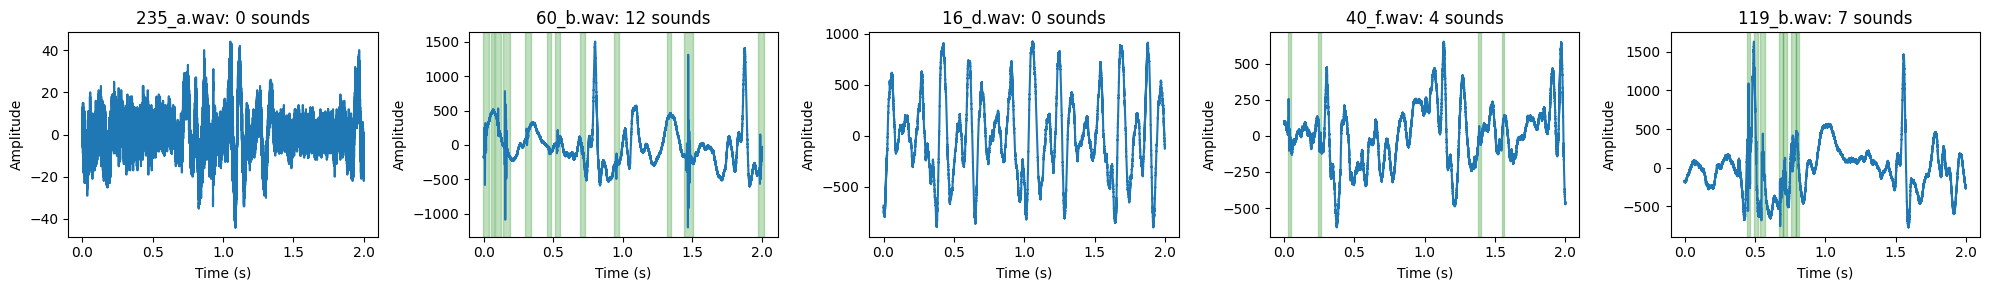

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
subset = random.sample(samples_train, 5)
for i, sample in enumerate(subset):
    plot_sample(sample, ax=ax[i])
plt.tight_layout()

Hm. It's not very obvious that the annotations actually correspond exactly to a meaningful position in the audio waveform. Maybe we need to try and apply a filter first. 

# Identifying Bowel Sounds

Let's first take an initial sample to work with.

In [15]:
sample = samples_train[14]

In [262]:
x = np.arange(0, sample.data.shape[0]) / sample.rate

<Axes: title={'center': '3_h.wav: 4 sounds'}, xlabel='Time (s)', ylabel='Amplitude'>

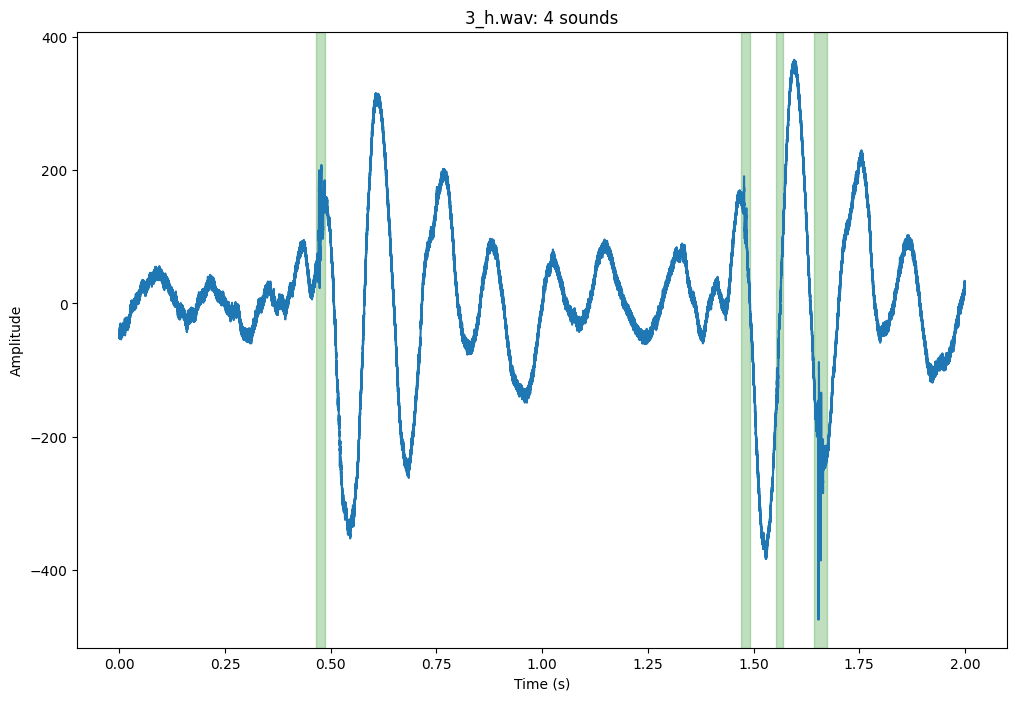

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
plot_sample(sample, ax=ax)

Let's use the following strategy:

1. Apply a Hann window to the whole signal
2. Band-pass filter (and visualise the Fourier transforms)
3. Identify peaks
4. Compare with the ground truth.

First, applying a Hann window to smooth the ends:

In [74]:
w = signal.get_window("hann", len(y))
y_windowed = y * w

<Axes: title={'center': '3_h.wav: 4 sounds'}, xlabel='Time (s)'>

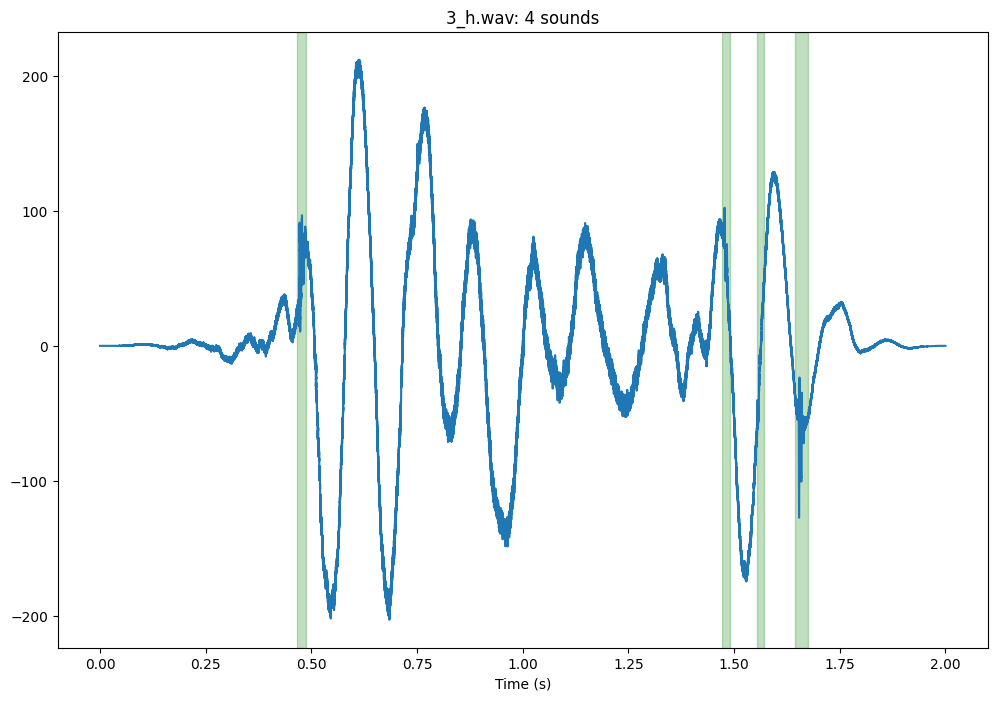

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
plot_with_annotation(sample, y_windowed, ax=ax)

We can look at the peaks in the frequency domain using a Fourier transform:

Text(0, 0.5, 'Magnitude')

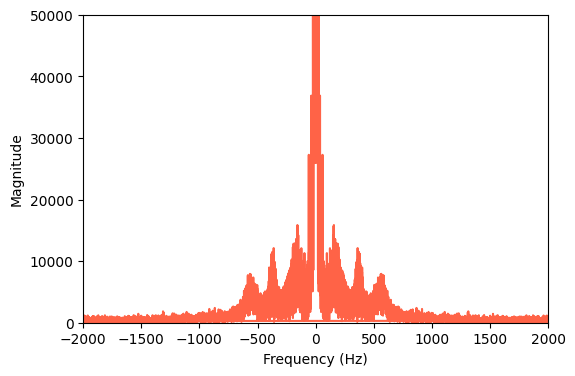

In [126]:
num_samples = len(sample.data)
yf = fft(y_windowed)
xf = fftfreq(num_samples, 1 / sample.rate)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.plot(xf, np.abs(yf), color="tomato")
plt.xlim(-2000, 2000)
plt.ylim(0, 50000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")

Apply a band pass filter from 100-500Hz (based on papers on bowel frequency characteristics):

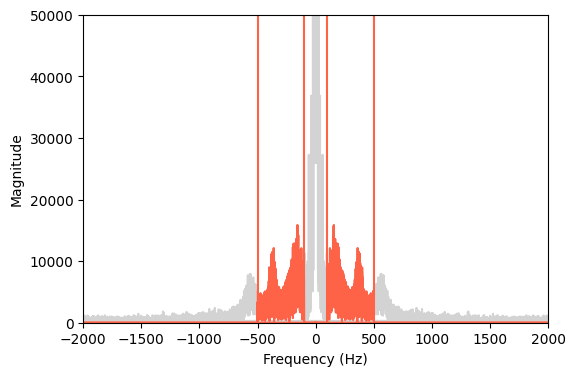

In [127]:
num_samples = len(sample.data)
yf = fft(y_windowed)
xf = fftfreq(num_samples, 1 / sample.rate)
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.plot(xf, np.abs(yf), color="lightgray")
fail_indices = [ not(abs(x) >= 100 and abs(x) <= 500) for x in xf]
yf[fail_indices] = 0
plt.plot(xf, np.abs(yf), color="tomato")
plt.xlim(-2000, 2000)
plt.ylim(0, 50000)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.vlines([-500, -100, 100, 500], 0, 50000, color="tomato")

Inverse Fourier transformation then gives us the following:

Text(0, 0.5, 'Amplitude')

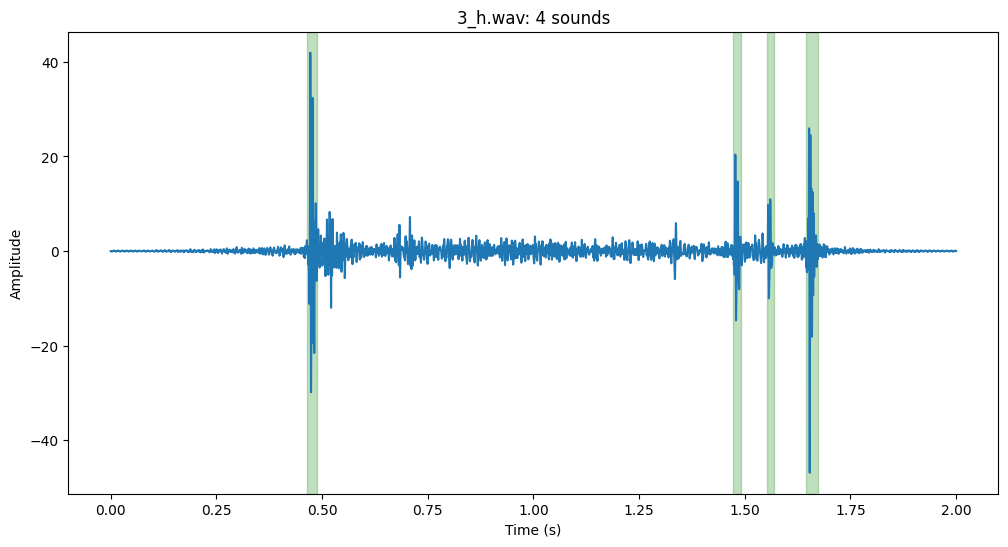

In [130]:
inverse = irfft(yf, num_samples)
fig, ax = plt.subplots(1, 1, figsize=(12,6))
plot_with_annotation(sample, inverse, ax=ax)
plt.ylabel("Amplitude")

The peaks now seem to align relatively well with the green, ground truth bowel sound regions.

Next, we should try to identify these peaks.

<Axes: title={'center': '3_h.wav: 4 sounds'}, xlabel='Time (s)'>

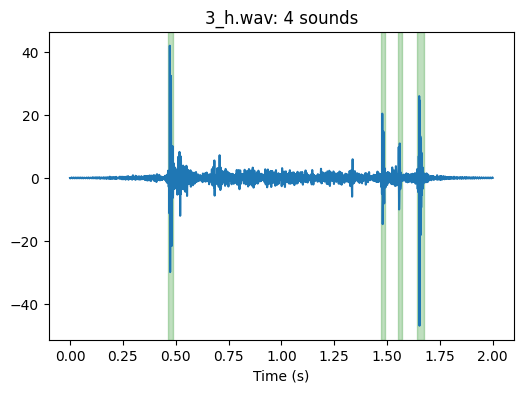

In [282]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plot_with_annotation(sample, inverse, ax=ax, alpha=0.25)

First, applying RMSD in windows quite aggressively:

In [257]:
width_rmsd=441
w_rmsd=np.ones(2*width_rmsd+1,'d')
y_avg=np.convolve(w_rmsd/w_rmsd.sum(),inverse,'same')
y_sd=(inverse-y_avg)**2
y_msd=np.convolve(w_rmsd/w_rmsd.sum(),y_sd,'same')
y_rmsd=y_msd**0.5

<Axes: title={'center': '3_h.wav: 4 sounds'}, xlabel='Time (s)'>

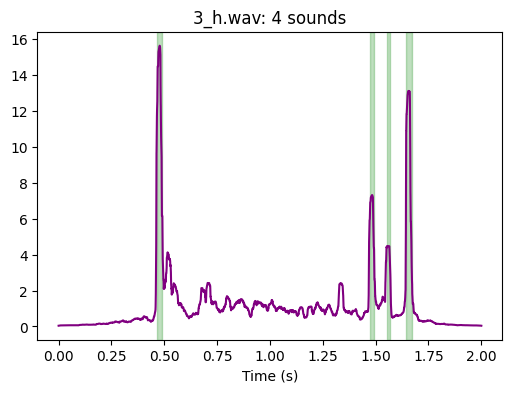

In [258]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_with_annotation(sample, y_rmsd, ax=ax, color="purple")

Thresholding:

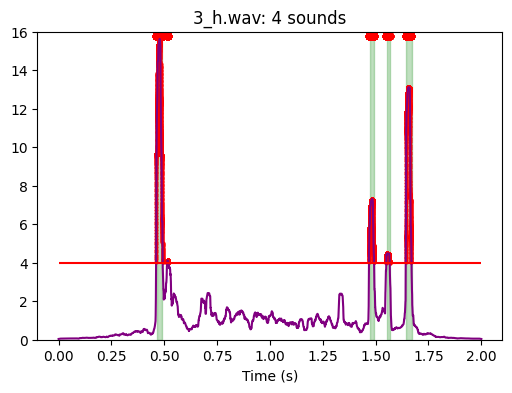

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_with_annotation(sample, y_rmsd, ax=ax, color="purple")
num_above_threshold = sum(y_rmsd > 4)
ax.scatter(x[y_rmsd > 4], [15.8] * num_above_threshold, color="red", s=20)
ax.scatter(x[y_rmsd > 4], y_rmsd[y_rmsd > 4], color="red", s=4)
ax.set_ylim(0, 16)
ax.hlines(4, 0, 2.00, color="red")

Merging nearby groups, filtering & identifying within-group maxima:

In [296]:
peaks = []
threshold = 4
min_peak_distance = 1102 # 25 ms
last_peak_end = - min_peak_distance - 1
in_peak = False
current_peak_start = 0 

# Iterate through each timepoint 
# If inside a peak, then continue until reach below threshold
# Once below threshold, store the peak's end and don't start a new peak until min_peak_distance has passed
# If not inside a peak, then continue until reach above threshold and min_peak_distance has passed
# If you encounter above threshold and min_peak_distance hasn't yet passed, then pop from peaks and keep adding to that peak 
# A peak is defined by a start and end timepoint
for i, rmsd in enumerate(y_rmsd):
    if in_peak:
        if rmsd < threshold:
            peaks.append((current_peak_start, last_peak_end))
            in_peak = False
        else:
            last_peak_end = i
    else:
        if rmsd > threshold:
            if i - last_peak_end > min_peak_distance:
                current_peak_start = i
                last_peak_end = i
                in_peak = True
            else:
                last_peak = peaks.pop()
                current_peak_start = last_peak[0]
                last_peak_end = i
                in_peak = True

max_peak_duration = 4410 # 100ms
filtered_peaks = [
    peak for peak in peaks if peak[1] - peak[0] < max_peak_duration
]

identified_peaks = [ np.argmax(y_rmsd[peak[0]:peak[1]]) + peak[0] for peak in filtered_peaks ]


In [297]:
identified_peaks

[21083, 65424, 68570, 72978]

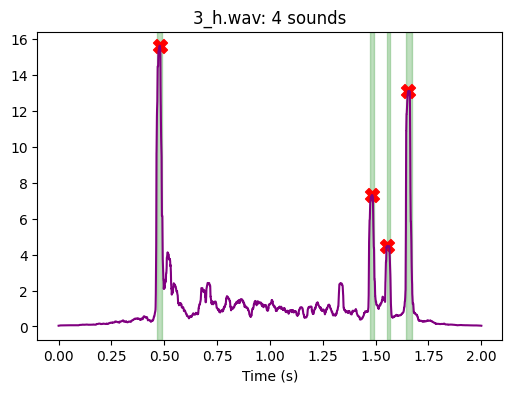

In [309]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plot_with_annotation(sample, y_rmsd, ax=ax, color="purple")
ax.scatter(x[identified_peaks], y_rmsd[identified_peaks], marker="X", color="red", s=100)

Putting it all together into one function:

In [339]:
def identify_sounds(sample: Sample, low_band=100, high_band=500, width_rmsd=441, rmsd_threshold=4, min_peak_distance=1102, max_peak_duration=4410, plot=False, ax=None): 
    x = np.arange(0, sample.data.shape[0]) / sample.rate
    y = sample.data

    # Hann window
    w = signal.get_window("hann", len(sample.data))
    y_windowed = y * w

    # Band pass filter
    num_samples = len(sample.data)
    yf = fft(y_windowed)
    xf = fftfreq(num_samples, 1 / sample.rate)
    fail_indices = [ not(abs(x) >= low_band and abs(x) <= high_band) for x in xf]
    yf[fail_indices] = 0
    inverse = irfft(yf, num_samples)

    # Identifying peaks 
    w_rmsd = np.ones(2*width_rmsd+1,'d')
    y_avg = np.convolve(w_rmsd/w_rmsd.sum(),inverse,'same')
    y_sd = (inverse-y_avg)**2
    y_msd = np.convolve(w_rmsd/w_rmsd.sum(),y_sd,'same')
    y_rmsd = y_msd**0.5

    peaks = []
    threshold = rmsd_threshold
    min_peak_distance = 1102 # 25 ms
    last_peak_end = - min_peak_distance - 1
    in_peak = False
    current_peak_start = 0

    for i, rmsd in enumerate(y_rmsd):
        if in_peak:
            if rmsd < threshold:
                peaks.append((current_peak_start, last_peak_end))
                in_peak = False
            else:
                last_peak_end = i
        else:
            if rmsd > threshold:
                if i - last_peak_end > min_peak_distance:
                    current_peak_start = i
                    last_peak_end = i
                    in_peak = True
                else:
                    last_peak = peaks.pop()
                    current_peak_start = last_peak[0]
                    last_peak_end = i
                    in_peak = True

    filtered_peaks = [ peak for peak in peaks if peak[1] - peak[0] < max_peak_duration ]
    identified_peaks = [ np.argmax(y_rmsd[peak[0]:peak[1]]) + peak[0] for peak in filtered_peaks ]

    if plot:
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        plot_with_annotation(sample, y_rmsd, ax=ax, color="purple")
        ax.scatter(x[identified_peaks], y_rmsd[identified_peaks], marker="X", color="red", s=100)
        return (identified_peaks, ax)

    return (identified_peaks, None)


Now testing it:

([21083, 65424, 68570, 72978],
 <Axes: title={'center': '3_h.wav: 4 sounds'}, xlabel='Time (s)'>)

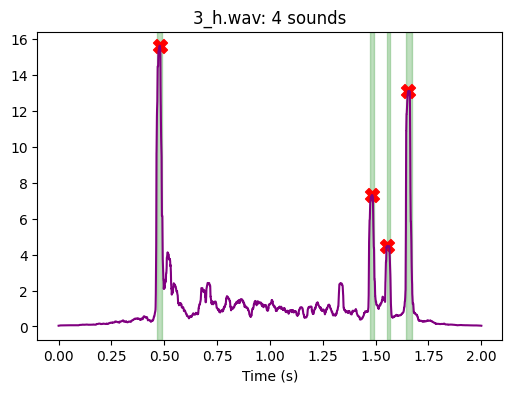

In [312]:
identify_sounds(samples_train[14], plot=True)

Alternatively, with find_peaks from scipy:

In [364]:
samples_with_instant_bowel_sounds = [sample for sample in samples_train if (sample.labels.end - sample.labels.start).max() < 0.05 and sample.data.std() < 30]

In [365]:
sample = [sample for sample in samples_with_instant_bowel_sounds if sample.filename=="8_h.wav"][0]

IndexError: list index out of range

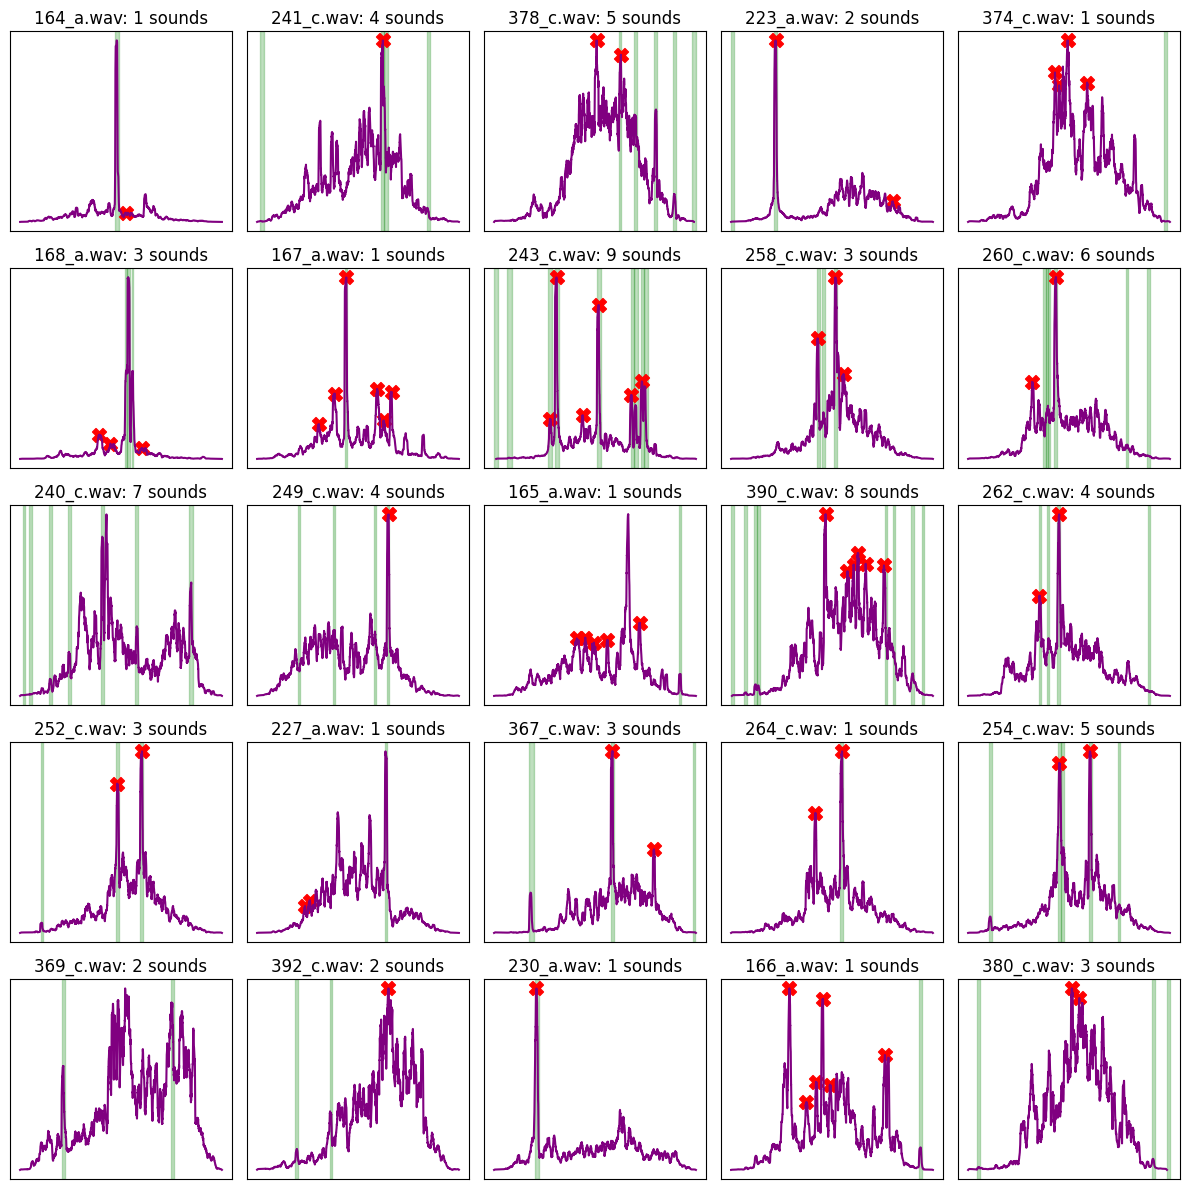

In [369]:
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
random_samples = random.sample(samples_with_instant_bowel_sounds, 25)
for i, sample in enumerate(random_samples):
    col = i // 5
    row  = i % 5
    identify_sounds(sample, plot=True, ax=ax[row][col], )
    # ax[row][col].set_title("")
    ax[row][col].set_xlabel("")
    ax[row][col].set_ylabel("")
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
plt.tight_layout()

In [383]:
num_sounds = 0 
num_sounds_in_labels = 0
for sample in samples:
    sounds = identify_sounds(sample, plot=False)[0]
    for sound in sounds:
        sound_time = sound / sample.rate
        num_sounds += 1
        for row in sample.labels.itertuples():
            if sound_time >= row.start and sound_time <= row.end:
                num_sounds_in_labels += 1
                break

In [384]:
print(num_sounds)
print(num_sounds_in_labels)
print(f"Percentage of sounds in labels: {num_sounds_in_labels / num_sounds * 100}%")

3802
1334
Percentage of sounds in labels: 35.08679642293529%


# References

Some useful references:
1. [Kolle 2019](https://doi.org/10.1186/s12938-019-0646-1): some useful information on characterization of bowel sounds. 
2. [Du 2018](https://doi.org/10.1121/1.5080528): mathematical model for bowel sound generation, with some useful information on characterisation.